In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from  sklearn.manifold import t_sne

sns.set()
os.chdir(f'{os.getenv("MT_SOURCE")}')
sys.path.append(os.getcwd())
os.getcwd()

'/Users/Play/Code/AI/master-thesis/src'

In [2]:
import constants as ct
import helpers as hp
import options.job_options as jo
import databunch.databunch as db

%matplotlib inline

In [7]:
def plot_class_tsne(_class_tsne: pd.DataFrame):
    sns.scatterplot('$x_0$', '$x_1$', hue='class', data=_class_tsne, palette='dark', legend=None)


def generate_tsne(_class_embeds: np.ndarray, _iloc2loc: pd.DataFrame,  _meta: pd.DataFrame) -> pd.DataFrame:
    _tsne = t_sne.TSNE(random_state=ct.RANDOM_STATE).fit_transform(_class_embeds)
    _df = pd.DataFrame(_tsne, columns=[r'$x_0$', r'$x_1$'])
    _loc = _iloc2loc['loc']
    _classes = _meta.reindex(_loc)[['label']].set_index(_df.index)['label']
    _df['class'] = _classes
    
    return _df


def plot_tsnes(_class_tsnes: pd.DataFrame, col: str, hue: str):
    _fig = sns.FacetGrid(_class_tsnes, 
                         height=8,
                         col=col, hue=hue, palette='dark', 
                         sharex=False, sharey=False)
    _fig.fig.set_dpi(180)
    _fig.fig.set_facecolor('white')
    _fig.map(sns.scatterplot, '$x_0$', '$x_1$')
    _fig.add_legend(ncol=2)
    plt.show()


def plot_splits_class_tsne(_splits):
    _tsnes = []
    for i, _split in enumerate(_splits):        
        _split_dir = ct.WORK_ROOT / SPEC.run_dir / _split
        _meta = hp.read_meta(getattr(DATABUNCH, f'{_split}_dso').do.meta_path)
        _iloc2loc = pd.read_parquet(_split_dir / 'iloc2loc.pqt', engine='pyarrow')
        _loc2iloc = pd.read_parquet(_split_dir / 'loc2iloc.pqt', engine='pyarrow')
        _class_embeds = np.load(_split_dir / 'class_embeds.npy')
        
        _tsne = generate_tsne(_class_embeds, _iloc2loc, _meta)
        _tsne['split'] = _split
        _tsnes.append(_tsne)
    
    _tsnes = pd.concat(_tsnes, ignore_index=True)
    plot_tsnes(_tsnes, 'split', 'class')


def plot_temp_class_tsnes(_split):
    _split_dir = ct.WORK_ROOT / SPEC.run_dir / _split 
    _meta = hp.read_meta(DATABUNCH.train_dso.do.meta_path)
    _iloc2loc = pd.read_parquet(_split_dir / 'iloc2loc.pqt', engine='pyarrow')
    _temporal_embeds = np.load(_split_dir / 'temporal_embeds.npy')
    _class_embeds = np.load(_split_dir / 'class_embeds.npy')
    
    b, t, *_ = _temporal_embeds.shape
    _temporal_embeds = _temporal_embeds.reshape(b, t, -1)
    _tsnes = []
    for i in range(t):
        temporal_embed = _temporal_embeds[:, i, :]
        _temporal_tsne = generate_tsne(temporal_embed, _iloc2loc, _meta)
        _temporal_tsne['time_step'] = str(i)
        _tsnes.append(_temporal_tsne)
    
    _class_tsne = generate_tsne(_class_embeds, _iloc2loc, _meta)
    _class_tsne['time_step'] = 'class_embed'
    _tsnes.append(_class_tsne)
    
    _tsnes = pd.concat(_tsnes, ignore_index=True)
    plot_tsnes(_tsnes, 'time_step', 'class')

In [8]:
SPEC = hp.load_spec(jo.RunExperimentOptions('hmdb1/tarn/class'))
SPEC.databunch.dlo.batch_size = 1
DATABUNCH = db.VideoDataBunch(SPEC.databunch)

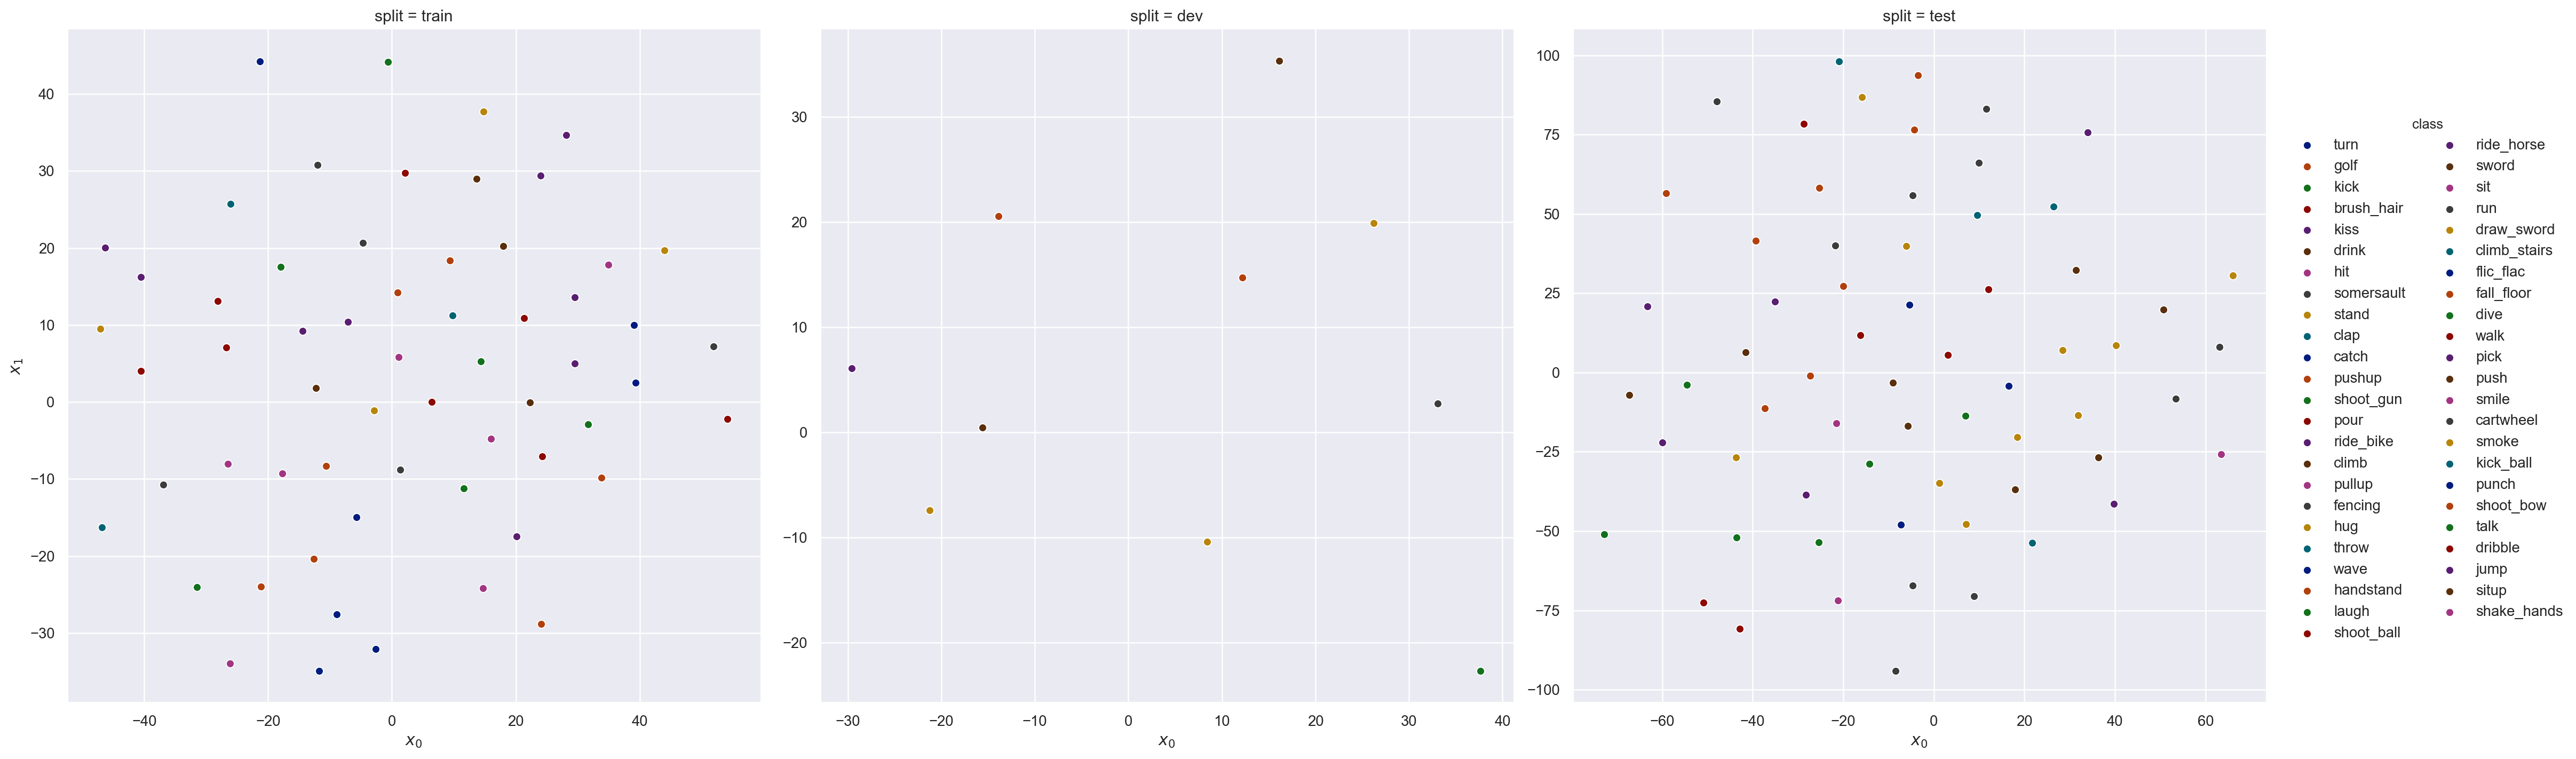

In [5]:
plot_splits_class_tsne(['train', 'dev', 'test'])

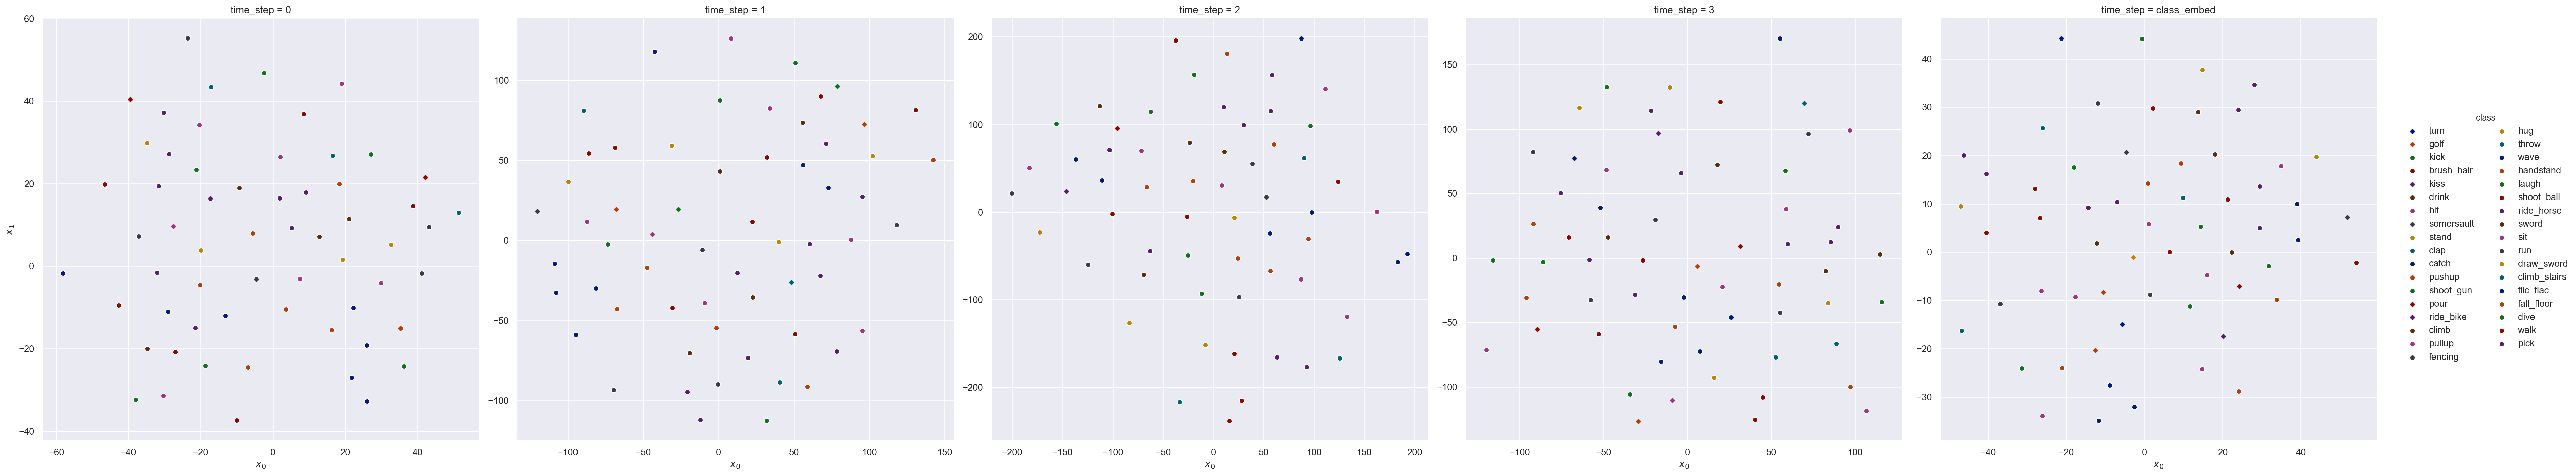

In [9]:
plot_temp_class_tsnes('train')